# Приоритизация гипотез для увеличения выручки интернет-магазина N, анализ A/B-теста

1. [Подготовка данных к анализу](#prepare)
2. [Часть 1: Приоритизация гипотез](#frameworks) 
    * [фреймворк ICE](#frameworks_ice)
    * [фреймворк RICE](#frameworks_rice)
    * [как изменилась приоритизация гипотез](#frameworks_summary)
3. [Часть 2: Анализ A/B-теста](#abtest) 
    * [График кумулятивной выручки по группам](#cumrevenue) 
    * [График кумулятивного среднего чека по группам](#cummean) 
    * [График относительного изменения кумулятивного среднего чека группы B к группе A](#cummeanbtoa) 
    * [График кумулятивной конверсии по группам](#conversion) 
    * [График относительного изменения кумулятивной конверсии группы B к группе A](#conversionbtoa) 
    * [Точечный график количества заказов по пользователям](#ordersperuser) 
    * [95-й и 99-й перцентили количества заказов на пользователя. Граница для определения аномальных пользователей](#orders9599)
    * [Точечный график стоимостей заказов](#cost) 
    * [95-й и 99-й перцентили стоимости заказов. Граница для определения аномальных заказов](#cost9599)
    * [Статистическая значимость различий в конверсии между группами по «сырым» данным](#pvalue_conversion_row) 
    * [Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным](#pvalue_mean_row) 
    * [Статистическая значимость различий в конверсии между группами по «очищенным» данным](#pvalue_conversion_filtered) 
    * [Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным](#pvalue_mean_filtered) 
6. [Решение по результатам теста](#summary) 

# Подготовка данных к анализу <a id="prepare"></a>

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

## Hypothesis

In [106]:
hyp=pd.read_csv('hypothesis.csv')
hyp

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Приведем названия колонок к нижнему регистру для удобства в следующих запросах.

In [107]:
hyp.columns = map(str.lower, hyp.columns)
hyp

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


## Orders

In [108]:
orders=pd.read_csv('orders.csv')
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [109]:
orders.columns=['orderId','userId','date','revenue','group']
orders.head()

,orderId,userId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [110]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   orderId  1197 non-null   int64 
 1   userId   1197 non-null   int64 
 2   date     1197 non-null   object
 3   revenue  1197 non-null   int64 
 4   group    1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [111]:
len(orders['userId'].unique())

1031

In [112]:
len(orders)

1197

В общей выборке 1031 уникальный пользватель. 

Переведем колонку с датами в формат даты. 

In [113]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   orderId  1197 non-null   int64         
 1   userId   1197 non-null   int64         
 2   date     1197 non-null   datetime64[ns]
 3   revenue  1197 non-null   int64         
 4   group    1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [114]:
orders['date'].describe()

count                    1197
unique                     31
top       2019-08-05 00:00:00
freq                       48
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

Данные за целый август 2019 года.

## Visitors

In [115]:
visitors=pd.read_csv('visitors.csv')
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [116]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Переведем колонку с датами в формат даты. 

In [117]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [118]:
visitors['visitors'].sum()

37652

# Часть 1: Приоритизация гипотез по увеличению прибыли интернет-магазина <a id="frameworks"></a>

## Фреймворк ICE  <a id="frameworks_ice"></a>   

In [119]:
hyp

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [120]:
hyp['hypothesis'].unique()

array(['Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей',
       'Запустить собственную службу доставки, что сократит срок доставки заказов',
       'Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа',
       'Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар',
       'Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей',
       'Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов',
       'Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию',
       'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок',
       'Запустить акцию, дающую скидку на товар в день рождения'],
      dtype=object)

In [121]:
hyp['ice']=(hyp['impact']*hyp['confidence'])/hyp['efforts']
hyp[['hypothesis','ice']].sort_values(by='ice',ascending=False).round(2)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день...",16.20
0,"Добавить два новых канала привлечения трафика,...",13.33
7,Добавить форму подписки на все основные страни...,11.20
6,Показать на главной странице баннеры с актуаль...,8.00
2,Добавить блоки рекомендаций товаров на сайт ин...,7.00
1,"Запустить собственную службу доставки, что сок...",2.00
5,"Добавить страницу отзывов клиентов о магазине,...",1.33
3,"Изменить структура категорий, что увеличит кон...",1.12
4,"Изменить цвет фона главной страницы, чтобы уве...",1.00


<div style="border:solid black 2px; padding: 20px"> По методу ICE, лидидуют гипотезы 8,0,7: акция на день рождения, два новых канала трафика, форма подписки по имейл. 

## Фреймворк RICE <a id="frameworks_rice"></a>

In [122]:
hyp['rice']=(hyp['reach']*hyp['impact']*hyp['confidence'])/hyp['efforts']
hyp[['hypothesis','rice']].sort_values(by='rice',ascending=False)

,hypothesis,rice
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


In [123]:
def lolipop_plot(df, metric):
    
    ordered_df = df.sort_values(by = metric).reset_index() 
    line_order = ordered_df.index 
    
    plt.hlines(y = line_order, xmin = 0, xmax = ordered_df[metric], color='skyblue') 
    plt.plot(ordered_df[metric], line_order, 'o') 
    
    plt.yticks(line_order, ordered_df['hypothesis'])
    plt.title(metric)

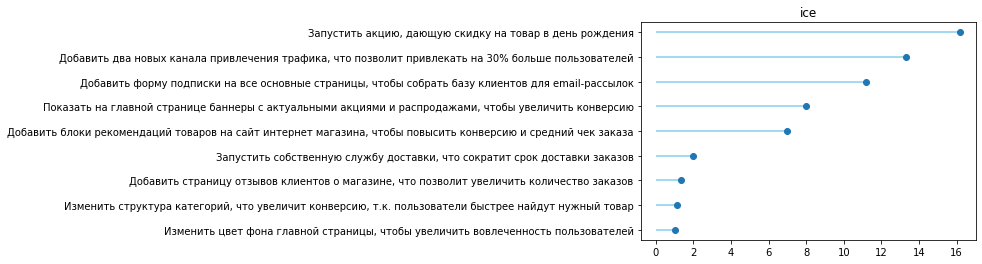

In [124]:
lolipop_plot(hyp, 'ice')

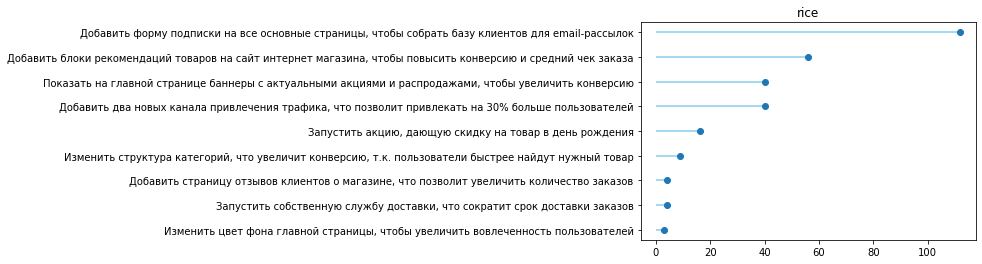

In [125]:
lolipop_plot(hyp, 'rice')

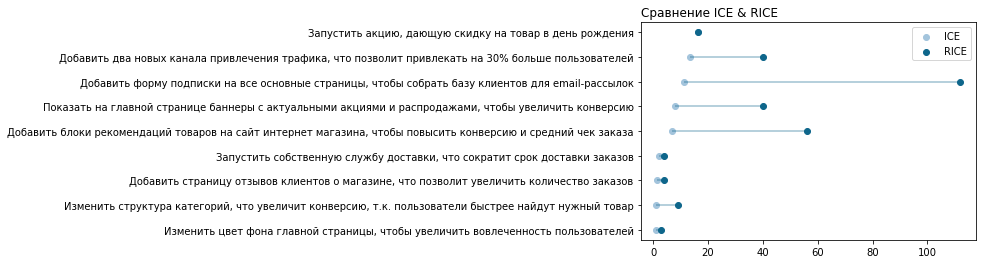

In [126]:
ordered_df = hyp.sort_values(by = 'ice').reset_index() 
line_order = ordered_df.index


plt.hlines(y = line_order, xmin = ordered_df['ice'], xmax = ordered_df['rice'], color = '#0e668b', alpha = 0.4)
plt.scatter(ordered_df['ice'], line_order, color = '#a3c4dc', label = 'ICE')
plt.scatter(ordered_df['rice'], line_order, color = '#0e668b', label = 'RICE')
plt.legend()


plt.yticks(line_order, ordered_df['hypothesis'])
plt.title('Сравнение ICE & RICE', loc = 'left')
plt.show()

<div style="border:solid black 2px; padding: 20px"> По методу RICE, лидируют гипотезы 7,2 и 0: форма подписки на имейл, рекомендация товаров, 2 новых канала трафика.

## Как изменилась приоритизация гипотез<a id="frameworks_summary"></a>

<div style="border:solid black 2px; padding: 20px"> Гипотеза 7 (ввести форму подписки на имейл) набрала больше баллов по метому RICE, потому что затрагивает максимальное покличество посетителей - 10 баллов из 10. 
      

Гипотеза 8 (акции на день рождения) совсем ушла из списка приоритетных гипотез, потому что затрагивает только посетителей в их день рождения. 
Зато появилась топ-гипотеза 2 (рекомендации товаров), потому что она охватывает гораздо большее число пользователей, чем, например, именинников. 
    
Так как в нашем случае важен именно охват (а не, например, качество аудитории, где от вип-клиентов гарантированно большая выручка), мы будем учитывать парамер охвата при приоритизации гипотез. 

# Часть 2: Анализ A/B-теста <a id="abtest"></a>  

In [127]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [128]:
orders.head()

,orderId,userId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


## График кумулятивной выручки по группам  <a id="cumrevenue"></a>  

In [129]:
#Создадим датафрейм datesGroups с уникальными парами значений 'date' и 'group', таблицы orders. 
#Избавимся от дубликатов  
datesGroups=orders[['date','group']]
datesGroups=orders[['date','group']].drop_duplicates()
datesGroups.head()

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


<div style="border:solid gold 2px; padding: 20px"> <h1 style="color:gold; margin-bottom:20px">Комментарий ревьюера</h1>

Ок, дубликаты это важно, НО
    
Здесь также нужно было посмотреть, что группы не пересекаются, это основное требование АВ теста
    
</div>

In [130]:
# Агригируем число уникальных заказов в группе теста по указанную дату включительно,
# а также число уникальных пользователей, совершивших хотя бы 1 заказ в группе теста по указанную дату включительно и
# суммарную выручку заказов в группе теста по указанную дату включительно.
ordersAggregated = (datesGroups
.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'orderId' : pd.Series.nunique, 'userId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1)
.sort_values(by=['date','group']) )
ordersAggregated.head()

,date,group,orderId,userId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


In [131]:
# Агригируем количество уникальных посетителей в группе теста по указанную дату включительно
visitorsAggregated=(datesGroups
       .apply(lambda x: visitors[np.logical_and(visitors['date']<=x['date'],visitors['group']==x['group'])]
       .agg({'date':'max','group':'max','visitors':'sum'}),axis=1)
       .sort_values(by=['date','group']))
visitorsAggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [132]:
# Объединим две таблицы
cumulativeData=ordersAggregated.merge(visitorsAggregated,  left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns=['date','group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


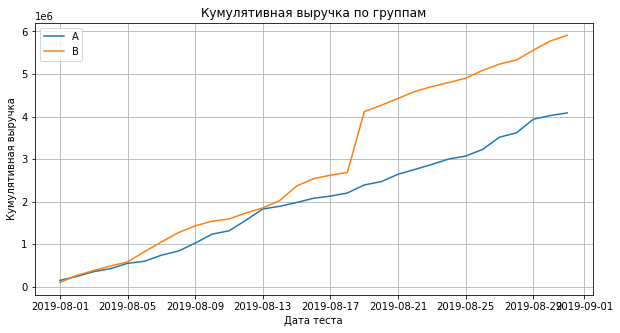

In [133]:
#Выделим выручку по группам теста и построим график.
cumulativeRevenueA=cumulativeData[cumulativeData['group']=='A'][['date','revenue','orders']]
cumulativeRevenueB=cumulativeData[cumulativeData['group']=='B'][['date','revenue','orders']]
plt.figure(figsize = (10, 5))
plt.plot(cumulativeRevenueA['date'],cumulativeRevenueA['revenue'],label='A')
plt.plot(cumulativeRevenueB['date'],cumulativeRevenueB['revenue'],label='B')
plt.legend()
plt.grid()
plt.xlabel('Дата теста')
plt.ylabel('Кумулятивная выручка')
plt.title('Кумулятивная выручка по группам')
plt.show()

<div style="border:solid black 2px; padding: 20px"> Группа Б лидирует по выручке, но на графике наблюдается аномальный скачок во второй половине теста.

## График кумулятивного среднего чека по группам<a id="cummean"></a>

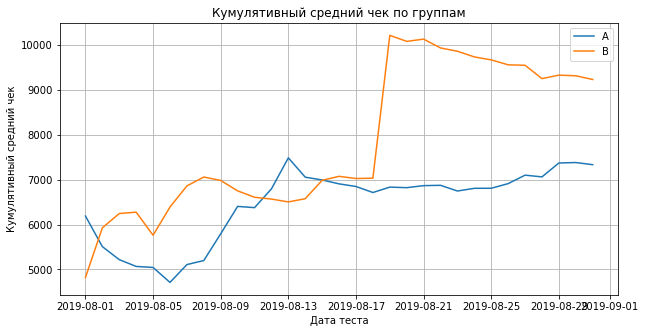

In [134]:
plt.figure(figsize = (10, 5))
plt.plot(cumulativeRevenueA['date'],cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'],cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.grid()
plt.xlabel('Дата теста')
plt.ylabel('Кумулятивный средний чек')
plt.title('Кумулятивный средний чек по группам')
plt.show()

<div style="border:solid black 2px; padding: 20px"> Снова видим, что группа Б лидирует по среднему чеку, но на графике теперь ещё больше скачков для обеих групп. 

## График относительного изменения кумулятивного среднего чека группы B к группе A <a id="cummeanbtoa"></a>

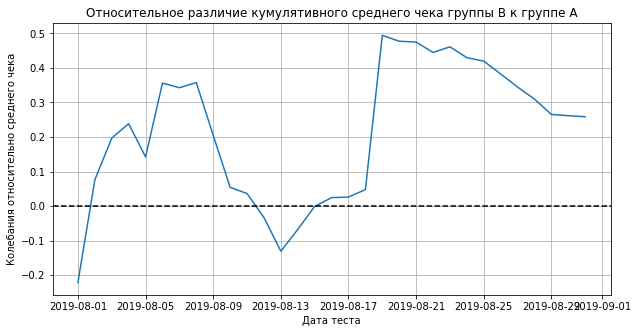

In [135]:
#Объединим таблицы cumulativeRevenueA и cumulativeRevenueB и построим график 
# относительно различия кумулятивного среднего чека группы B к группе A. 
mergedCumulativeRevenue=(cumulativeRevenueA
                         .merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A','B']))
plt.figure(figsize = (10, 5))
plt.plot(mergedCumulativeRevenue['date'],(mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0,color='black',linestyle='--')
plt.grid()
plt.xlabel('Дата теста')
plt.ylabel('Колебания относительно среднего чека')
plt.title('Относительное различие кумулятивного среднего чека группы B к группе A')
plt.show()

<div style="border:solid black 2px; padding: 20px"> В нескольких точках график различия между сегментами резко «скачет». Причина, скорее всего, -  крупные заказы и выбросы. 

##  График кумулятивной конверсии по группам <a id="conversion"></a>

In [136]:
#Добавим в cumulativeData столбец 'conversion' c отношением числа заказов к количеству пользователей 
# в указанной группе в указанный день.
cumulativeData['conversion']=cumulativeData['orders']/cumulativeData['visitors']
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
1,2019-08-01,B,21,20,101217,713,0.029453
2,2019-08-02,A,44,38,242401,1338,0.032885
3,2019-08-02,B,45,43,266748,1294,0.034776
4,2019-08-03,A,68,62,354874,1845,0.036856


In [137]:
#Выделим группы А и B
cumulativeDataA=cumulativeData[cumulativeData['group']=='A']
cumulativeDataB=cumulativeData[cumulativeData['group']=='B']
cumulativeDataB['conversion'].describe()

count    31.000000
mean      0.033855
std       0.001469
min       0.029453
25%       0.033595
50%       0.034011
75%       0.034595
max       0.036323
Name: conversion, dtype: float64

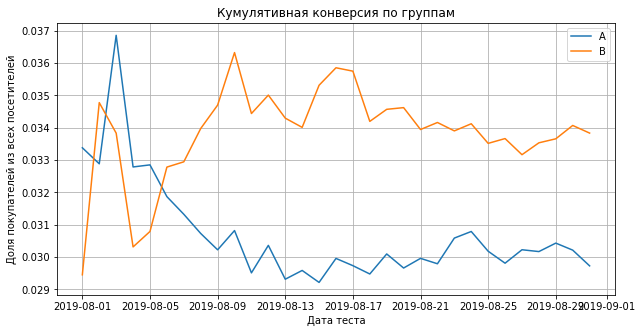

In [138]:
# Построим графики кумулятивной конверсии
plt.figure(figsize = (10, 5))
plt.plot(cumulativeDataA['date'],cumulativeDataA['conversion'],label='A')
plt.plot(cumulativeDataB['date'],cumulativeDataB['conversion'],label='B')
plt.legend()
plt.grid()
plt.xlabel('Дата теста')
plt.ylabel('Доля покупателей из всех посетителей')
plt.title('Кумулятивная конверсия по группам')
plt.show()

<div style="border:solid black 2px; padding: 20px"> В начале теста лидировала группа А по конверсии, но постепенно группа B стала лидировать и зафиксировалась на примерно том же уровне больше значений группы А. 

##  График относительного изменения кумулятивной конверсии группы B к группе A <a id="conversionbtoa"></a>

In [139]:
# Объединим таблицы cumulativeDataA и cumulativeDataB
mergedCumulativeConversions = (cumulativeDataA[['date','conversion']]
                               .merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B']))
mergedCumulativeConversions.head()

,date,conversionA,conversionB
0,2019-08-01,0.033380,0.029453
1,2019-08-02,0.032885,0.034776
2,2019-08-03,0.036856,0.033833
3,2019-08-04,0.032787,0.030315
4,2019-08-05,0.032851,0.030793


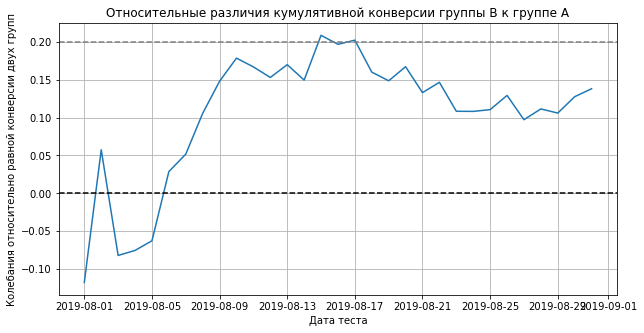

In [140]:
# Построим график относительно различия кумулятивной конверсии группы B к группе A. 
plt.figure(figsize = (10, 5))
plt.plot(mergedCumulativeConversions['date'],mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.grid()
plt.xlabel('Дата теста')
plt.ylabel('Колебания относительно равной конверсии двух групп')
plt.title('Относительные различия кумулятивной конверсии группы B к группе A')
plt.show()

Группа B лидирует по конверсии, в середине теста достигает разницы в 20% относительно группы А, потом держится на 10%. 


## Точечный график количества заказов по пользователям <a id="ordersperuser"></a>

Мы видели нестабильные графики, которые говорят нам об аномальных заказах, то есть выбросах. Настало время обозначить границу аномальных значений, чтобы проверить выборки без них.

Найдем число заказов по пользователям.

In [141]:
ordersByUsers=orders.drop(['group','revenue','date'],axis=1).groupby('userId', as_index=False).agg({'orderId': pd.Series.nunique})
ordersByUsers.columns=['userId','orders']
ordersByUsers.head()

,userId,orders
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1


Построим гистограмму распределения числа заказов по пользователям.

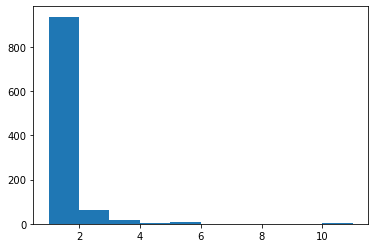

In [142]:
ordersByUsers.sort_values(by='orders',ascending=False)
plt.hist(ordersByUsers['orders']) 
plt.show()

Большинство пользователей сделало всего 1 заказ, заметны также пользователи с двумя-тремя заказами, есть какие-то данные и для пользователей с более чем 10 заказов. Построим график вида scatter, чтобы лучше рассмотреть

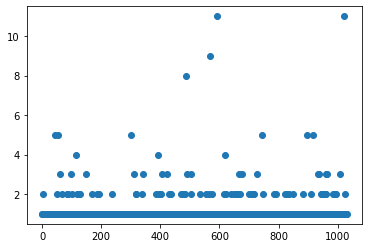

In [143]:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.show()

Больше трех заказов встречается нечасто. Посчитаем выборочные перцентили.

## 95-й и 99-й перцентили количества заказов на пользователя. Граница для определения аномальных пользователей   <a id="orders9599"></a>

In [144]:
np.percentile(ordersByUsers['orders'], [90, 95, 99])

array([1., 2., 4.])

<div style="border:solid black 2px; padding: 20px">  Не более 5% пользователей совершили более двух заказов и не более 1% - более четырех заказов. Предлагаю выбрать 2 заказа за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней.

## Точечный график стоимостей заказов <a id="cost"></a>

Построим гистограмму распределения выручек ('revenue') с заказов по пользователям

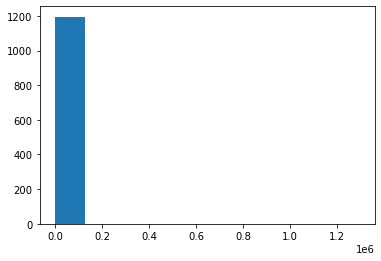

In [145]:
orders.sort_values(by='revenue',ascending=False)
plt.hist(orders['revenue'])
plt.show()

Посмотрим чуть ближе.

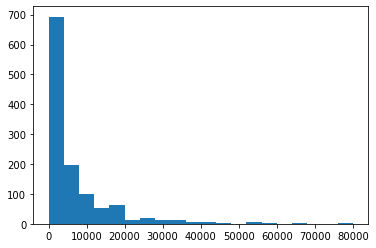

In [146]:
plt.hist(orders['revenue'],range=(0,80000),bins=20)
plt.show()

Сумма большинства заказов 20 000, достаточно много заказов до 40 тыс, поменьще - до 60 тыс. Распределение ненормальное, непонятно, какое количество более дорогих и дешевых заказов.  

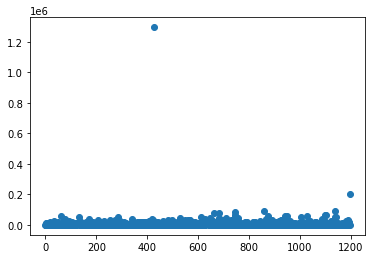

In [147]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values,orders['revenue'])
plt.show()

Видно только два явных выброса - около 200 000 и 1 200 000. Посмотрим перцентили. 

## 95-й и 99-й перцентили стоимости заказов. Граница для определения аномальных заказов<a id="cost9599"></a>

In [148]:
np.percentile(orders['revenue'],[90,95,99])

array([18168. , 28000. , 58233.2])

<div style="border:solid black 2px; padding: 20px">  Не более 5% посетителей заказывают на сумму больще 28 000, не больше 1% - на сумму 58 000. Возьмём за нижнюю границу 28 000.

## Статистическая значимость различий в конверсии между группами по «сырым» данным <a id="pvalue_conversion_row"></a>

In [149]:
#Сначала создадим фрейм, в котором будут отображаться количество посетителей выбранной группы в день. 
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
visitorsADaily.head(2)

,date,visitorsPerDateA
0,2019-08-01,719
1,2019-08-02,619


In [150]:
#Выведем накопительную сумму посетителей за каждый день теста. 
visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']
visitorsACummulative.head()

,date,visitorsCummulativeA
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318


In [151]:
#Проделаем то же самое для группы B. 
visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']
visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']
visitorsBCummulative.head()

,date,visitorsCummulativeB
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803
34,2019-08-04,2573
35,2019-08-05,3280


In [152]:
orders.head(2)

,orderId,userId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B


Теперь посмотрим количество и размер заказов в день в каждой тестовой группе.

In [153]:
#Таблица для группы А, разбивка на каждый день. 
ordersADaily = orders[orders['group']=='A'][['date', 'orderId', 'userId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'orderId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']
ordersADaily.head()

,date,ordersPerDateA,revenuePerDateA
0,2019-08-01,24,148579
1,2019-08-02,20,93822
2,2019-08-03,24,112473
3,2019-08-04,16,70825
4,2019-08-05,25,124218


In [154]:
#Теперь посчитаем коммулятивные данные на каждый день для группы А. 
ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']
ordersACummulative.head()

,date,ordersCummulativeA,revenueCummulativeA
0,2019-08-01,24,148579
1,2019-08-02,44,242401
2,2019-08-03,68,354874
3,2019-08-04,84,425699
4,2019-08-05,109,549917


In [155]:
# То же самое сделаем для группы Б
ordersBDaily = orders[orders['group']=='B'][['date', 'orderId', 'userId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'orderId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']
ordersBCummulative.head()

,date,ordersCummulativeB,revenueCummulativeB
0,2019-08-01,21,101217
1,2019-08-02,45,266748
2,2019-08-03,61,380996
3,2019-08-04,78,489567
4,2019-08-05,101,581995


По дате соединим таблицы с данными по количеству заказов и посетителей в день, а также кумулятивные данные по количеству визитов, заказов и сумме заказов.

In [156]:
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Выделим пользователей, совершивших хотя бы 1 заказ, и число их заказов в группе. 

In [157]:
# группа А
ordersByUsersA=orders[orders['group']=='A'].groupby('userId',as_index=False).agg({'orderId':pd.Series.nunique})
ordersByUsersA.columns=['userId','orders']
ordersByUsersA.head()

,userId,orders
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1


In [158]:
# Группа Б
ordersByUsersB=orders[orders['group']=='B'].groupby('userId',as_index=False).agg({'orderId':pd.Series.nunique})
ordersByUsersB.columns=['userId','orders']
ordersByUsersB.head()

,userId,orders
0,5114589,1
1,6958315,1
2,8300375,1
3,39475350,1
4,47206413,1


Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. 

In [159]:
import scipy.stats as stats
sampleA=pd.concat([ordersByUsersA['orders'], pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum()-len(ordersByUsersA['orders'])), name='orders')], axis=0)
sampleB=pd.concat([ordersByUsersB['orders'], pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum()-len(ordersByUsersB['orders'])), name='orders')], axis=0)

Применим критерий и отформатируем p-value, округлив его до пяти знаков после запятой.

In [160]:
"{0:.5f}".format(stats.mannwhitneyu(sampleA,sampleB)[1])

'0.00840'

<div style="border:solid black 2px; padding: 20px"> p-value меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Анализ сырых данных сообщает, что в конверсии между группами есть статистически значимые различия. 

Выведем относительный прирост конверсии группы B: конверсия группы B / конверсия группы A - 1. Округлим до трёх знаков после запятой.

In [161]:
"{0:.3f}".format((data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1)

'0.138'

<div style="border:solid black 2px; padding: 20px"> Относительный прирост конверсии группы Б к группе А составляет  13.8% по сырым данным.

##   Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным<a id="pvalue_mean_row"></a> 

In [162]:
"{0:.3f}".format((stats
                  .mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

'0.365'

In [163]:
"{0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1) 

'0.259'

<div style="border:solid black 2px; padding: 20px"> По сырым данным, средний чек группы B больше на 25%. Но статистически значимых различий между средними чеками групп нет, так как p-value больше 0.05.

##   Статистическая значимость различий в конверсии между группами по «очищенным» данным <a id="pvalue_conversion_filtered"></a>

Очистим таблицы от аномальных данных. Напомним, что 95-й и 99-й перцентили средних чеков равны 28000 и 58233.2 рублям. А 95-й и 99-й перцентили числа заказов на одного пользователя равны 2 и 4 заказам на пользователя. Примем за аномальных пользователей тех, кто совершил 2 заказа и более, или совершил заказ на сумму свыше 28 000 рублей. Так мы уберём от 1% до 5% пользователей с наибольшим числом заказов и около 5% заказов с наибольшей стоимостью.

Сделаем срезы с аномальныим пользователями.

In [164]:
ordersByUsersA.head()

,userId,orders
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1


In [165]:
# Пользователи с большим количеством заказов
usersWithManyOrders=(pd
                     .concat([ordersByUsersA[ordersByUsersA['orders']>2]['userId'], 
                              ordersByUsersB[ordersByUsersB['orders']>2]['userId']], axis=0))
len(usersWithManyOrders)

24

In [166]:
# Пользователи с дорогими заказами
usersWithExpensiveOrders=orders[orders['revenue']>28000]['userId']
len(usersWithExpensiveOrders)

60

In [167]:
# Объединим таблицы и удалим дупликаты. 
abnormalUsers=pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates().sort_values()
len(abnormalUsers)

74

Придётся удалить 74 пользователя из выборки с 1031 человек, примерно 7%. 

Создадим переменные sampleAFiltered и sampleBFiltered, в которых сохраним очищенные данные о заказах — не включая аномальных пользователей. 

In [168]:
sampleAFiltered=(pd
                 .concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'], 
                          pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
                                    name='orders')], axis=0))
len(sampleAFiltered)

18690

In [169]:
sampleBFiltered=(pd
                 .concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'], 
                          pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
                                    name='orders')], axis=0))
len(sampleBFiltered)

18869

In [170]:
visitors['visitors'].sum()

37652

In [171]:
visitors['visitors'].sum() -(len(sampleAFiltered)+len(sampleBFiltered))

93

Выведем p-value для сравнения конверсии между очищенными группами. 

In [172]:
"{0:.5f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1])

'0.00652'

<div style="border:solid black 2px; padding: 20px"> Как и в случае с сырыми данными, статистическая значимость для сравнения выборок по конверсии достигнута. 

Посмотрим прирост конверсии группы B. 

In [173]:
print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.173


<div style="border:solid black 2px; padding: 20px"> В очищенных данных прирост конверсии составляет 14.8 процентов, даже больше чем по сырым данным на процент. 

##  Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным <a id="pvalue_mean_filtered"></a>

Выведем p-value для сравнения средних чеков между очищенными группами. 

In [174]:
"{0:.3f}".format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['userId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['userId'].isin(abnormalUsers)))]['revenue'])[1])

'0.369'

Даже после очистки данных не получилось достигнуть статистической значимости. 

Относительный прирост среднего чека очищенной группы B

In [175]:
"{0:.3f}".format(
orders[np.logical_and(orders['group']=='B', np.logical_not(orders['userId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
    orders['group']=='A',
    np.logical_not(orders['userId'].isin(abnormalUsers)))]['revenue'].mean() -1 )

'-0.020'

По очищенным данным средний чек группы B оказался примерно тем же, что и в группе А и даже чуть меньше. Но разница всё равно статистически не значимая. 

# Решение по результатам теста <a id="summary"></a>

Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий. График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту, либо зафиксировались около среднего значения: [График относительного изменения кумулятивной конверсии группы B к группе A](#conversionbtoa). В очищенных данных прирост конверсии составляет 14.8 процентов, на процент больше, чем в сырых.

Однако, и по сырым, и по очищенным данным нет статистически значимого различия по среднему чеку между группами. 

Исходя из фактов выше, стоит остановить тест, признать, что эксперимент положительно сказался на конверсии, но не повлиял на средний чек.